# Credit Risk Model on Lending Club Loan Data

In this kernel I will be going over the Lending Club Loan Data where the data is imbalanced, big and has multiple features with different data types. For the purpose of modelling, I will be taking all default loans as the target variable and will be trying to predict if a loan will default or not.

---


# Importing the data

First, importing necessary libraries,

In [1]:
#Imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

In [2]:
start_df = pd.read_csv('./loan.csv', low_memory=False)

Working on a copy of the dataframe so that I do not have to re-read the entire dataset again in order to save memory.

In [3]:
df = start_df.copy(deep=True)
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking the dimensions,

In [4]:
df.shape

(887383, 75)

So, we've got a fair amount of columns that we need to understand. Knowing what the columns mean can help us a lot for feature engineering later on.

---

# Understanding the data 

In [5]:
df.loan_status.value_counts()

Current                                                601781
Fully Paid                                             207724
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [6]:
df = df.loc[df['loan_status'].isin(['Charged Off', 'Fully Paid', 'Default'])]

In [7]:
df.loan_status.value_counts()

Fully Paid     207724
Charged Off     45248
Default          1219
Name: loan_status, dtype: int64

First, let's check the description of the various column fields in the dataset.

In [8]:
df_description = pd.read_excel('./LCDataDictionary.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


> Looking at the columns description, a good thing we could do is find columns that carry importance and at the same time find columns that are redundant for their lack of information.


Let us also see the number and percentage of missing values,

These columns either leak data or do not contribute towardsloan default prediction.

In [9]:
drop_cols = [ 'zip_code','out_prncp','out_prncp_inv', 'title', 'desc', 'url',
             'total_pymnt','total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt', 'id','member_id','funded_amnt','funded_amnt_inv',
             'emp_title','issue_d', 'index', 'addr_state']

df.drop(drop_cols, axis=1, inplace=True)

In [10]:
df.shape

(254191, 53)

In [11]:
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [12]:
# Missing values statistics
miss_values = null_values(df)
miss_values.head(20)

Dataframe has 53 columns.
There are 28 columns that have missing values.


,Missing Values,% of Total Values
annual_inc_joint,254190,100.0
dti_joint,254190,100.0
verification_status_joint,254190,100.0
il_util,254065,100.0
mths_since_rcnt_il,254051,99.9
open_il_6m,254047,99.9
open_il_12m,254047,99.9
total_cu_tl,254047,99.9
inq_fi,254047,99.9
all_util,254047,99.9


> The percentage of missing data in many columns are far more than we can work with. So, we'll have to remove columns having a certain percentage of data less than the total data later on.

Another thing we would want to examine is that how many loans have a default loan status in comparison to other loans. A common thing to predict in datasets like these are if a new loan will get default or not. I'll be keeping loans with default status as my target variable.

In [13]:
target_list = [0 if i=='Fully Paid' else 1 for i in df['loan_status']]

df['TARGET'] = target_list
df['TARGET'].value_counts()

0    207724
1     46467
Name: TARGET, dtype: int64

> This clearly is a case of an imbalanced class problem where the value of class is far less than the other. There are cost function based approaches and sampling based approaches for handling this kind of problem which we will use later so that our model doesn't exhibit high bias while trying to predict if a loan will default or not.

In [14]:
df.drop('loan_status',axis=1,inplace=True)

Then, seeing the distribution of data types we are working with,

Text(0,0.5,'Data type')

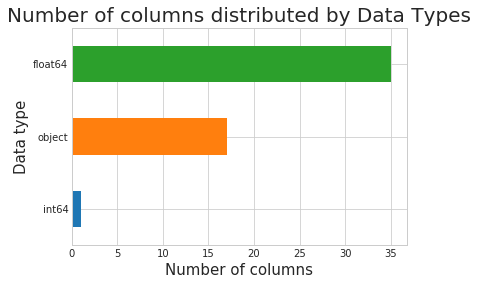

In [15]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

> So we have quite a number of columns having objects data type which are going to pose a problem while modelling. 

Let us see how many categorical data do the columns having 'object' data types contain:

In [16]:
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                            2
int_rate                      513
grade                           7
sub_grade                      35
emp_length                     11
home_ownership                  6
verification_status             3
pymnt_plan                      2
purpose                        14
addr_state                     51
earliest_cr_line              645
revol_util                   1199
initial_list_status             2
next_pymnt_d                    2
last_credit_pull_d            102
application_type                2
verification_status_joint       1
dtype: int64

>  We would want to label encode the columns having only 2 categorical data and one-hot encode columns with more than 2 categorical data. Also, columns like emp_title, url, desc, etc. should be dropped because there aren't any large number of unique data for any of the categories they contain. Also, Principal Component Analysis can be carried out for the one-hot encoded columns to bring the feature dimensions down.

## Anomaly Detection

Let us check for any anomalies on the data we might have. Possible data anamolies are often found in columns dealing with time like years of employment. Let's quickly go through them.

In [17]:
df['emp_length'].head(3)

0    10+ years
1     < 1 year
2    10+ years
Name: emp_length, dtype: object

I'll be filling the null values with 0 assuming that the borrower hasn't worked many years for his data to be recorded. Also, I'll be using regex to extract the number of years from all of the data.

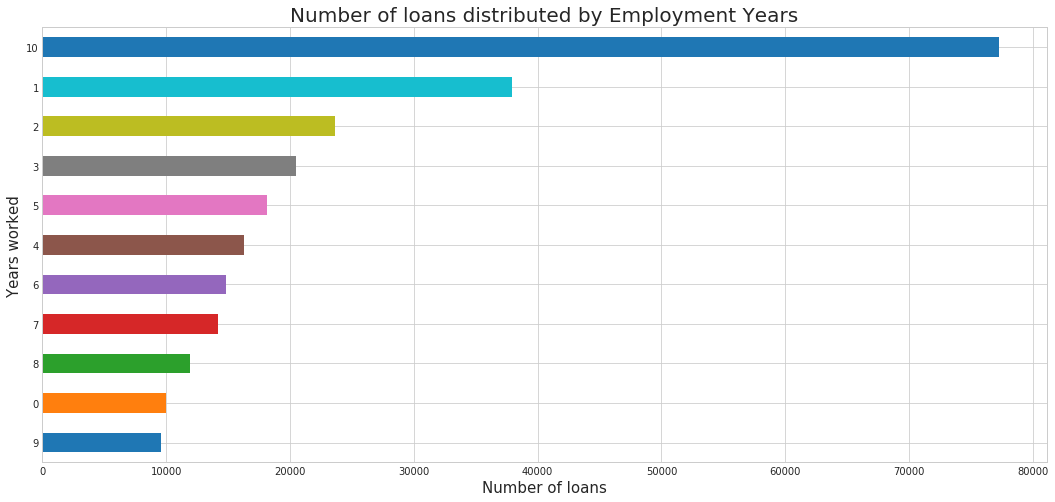

In [18]:
df['emp_length'].fillna(value=0,inplace=True)

df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

df['emp_length'].value_counts().sort_values().plot(kind='barh',figsize=(18,8))
plt.title('Number of loans distributed by Employment Years',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Years worked',fontsize=15);

> The column looks fine. Also, it can be seen that people who have worked for 10 or more years are more likely to take a loan.

Let me remove all the columns with more than 70% missing data as they won't be helping for modelling and exploration.

In [19]:
temp = [i for i in df.count()<254191 *0.30]
df.drop(df.columns[temp],axis=1,inplace=True)

In [20]:
df['application_type'].value_counts()

INDIVIDUAL    254190
JOINT              1
Name: application_type, dtype: int64

> Seeing the number of joint applicants in comparison to the the total applicants, it **isn't** significant enough to conclude that the loan taken by all Joint applicants are paid back. 

# Cleaning the data


As we had observe, some columns like annual_inc, int_rate, etc. may be much useful for building our model but on the other hand, some columns like id, member_id, etc. will not be helping. 

Also, columns like 'title' and 'emp_title' are text which cannot be one-hot encoded / label encoded as they have arbitrary categorical text and very less unique data for each of their categories.

In [21]:
df.shape

(254191, 33)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254191 entries, 0 to 887375
Data columns (total 33 columns):
loan_amnt                     254191 non-null float64
term                          254191 non-null object
int_rate                      254191 non-null object
installment                   254191 non-null float64
grade                         254191 non-null object
sub_grade                     254191 non-null object
emp_length                    254191 non-null object
home_ownership                254191 non-null object
annual_inc                    254191 non-null float64
verification_status           254191 non-null object
pymnt_plan                    254191 non-null object
purpose                       254191 non-null object
addr_state                    254191 non-null object
dti                           254191 non-null float64
delinq_2yrs                   254191 non-null float64
earliest_cr_line              254191 non-null object
inq_last_6mths                254191

Some of these columns still look like they could need some work i.e. more cleaning! 

I will be fixing the data types and then handling the missing data.

First, I'll be converting the date object columns into integer number of years or months just because I do not want to blow up the number of feature columns by performing one-hot encoding on them. For filling the null values I have taken the dates with the highest number of counts.

In [23]:
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'].fillna("2016-01-01")).apply(lambda x: int(x.strftime('%m')))
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%m')))


Let's see how we can handle our categorical data. Two methods we can use are Label Encoding and One Hot Encoding.

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. So, If we only have two unique values for a categorical variable (such as Yes/No), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the better option.

However, due to the large number of columns originated after One-Hot Encoding, we may have to conduct Principle Component Analysis (PCA) for dimensionality reduction.

In [24]:
from sklearn import preprocessing

In [25]:
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
pymnt_plan
initial_list_status
application_type
4 columns were label encoded.


And one-hot encoding the rest categorical columns,

In [26]:
df.int_rate = df['int_rate'].map(lambda x: x.rstrip('%'))
df.int_rate = df.int_rate.astype('float64')

In [27]:
df.revol_util = df.revol_util.astype(str).map(lambda x: x.rstrip('%'))
df.revol_util = df.revol_util.astype('float64')

In [28]:
df.emp_length = df.emp_length.astype('float64')

For the 'mths_since_last_delinq' column, I'll be filling in the missing value with the median of the columns as the data in the column is continuous.

In [29]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(df['mths_since_last_delinq'].median())

However for columns like 'total_rev_hi_lim','tot_col_ammnt',etc. , I won't be filling in the missing data because they will certainly be of high feature importance due to their description. If they do not seem to be of high importance we can always re-iterate and fill the missing values later. 

So, dropping all remaining null values,

In [30]:
df.dropna(inplace=True)

In [31]:
df2 = pd.get_dummies(df)
df2.shape

(190344, 141)

In [32]:
df['TARGET'].value_counts()

0    153938
1     36406
Name: TARGET, dtype: int64

We are now left with a reasonable amount of data for modelling.

---

# Train-Test Split

In [88]:
from sklearn.model_selection import train_test_split

X = df2.drop('TARGET', axis=1)
y = df2.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [89]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [90]:
for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'int64']:
        X_train[col] = sc.fit_transform(X_train[col].reshape(-1,1))

for col in X_test.columns:
    if X_test[col].dtype in ['float64', 'int64']:
        X_test[col] = sc.transform(X_test[col].reshape(-1,1))

/home/gyanendra/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gyanendra/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gyanendra/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [91]:
# Variance Threshold
drop_list = []
for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'int64']:
        if np.var(X_train[col]) < 0.0001:
            drop_list.append(col)

In [92]:
X_train.drop(drop_list, axis=1, inplace=True)

X_test.drop(drop_list, axis=1, inplace=True)

/home/gyanendra/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/gyanendra/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Feature Selection

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

In [80]:
indices[:75]

array([100,  92, 107,  58,  57, 108,  25,  60,  56,  23,  76,  24,  55,
        61,  22,  27,  53,  26,  54,  16,  52, 125,  51,  49,  47,  50,
       105,  80,  79, 120, 104,  46, 129,  29,  28,  87, 128,  48,  21,
        78,  71, 109,  17,  88,  44,  74,  67,  20, 118,  91,  45,  30,
        43,  32, 123, 119,  82, 111,  39,  41,  95,  73, 116,  37, 127,
        18,  31,  19, 115,  33,  40,  72,  96,  38,  42])

In [81]:
importances = clf.feature_importances_
indices = np.argsort(importances)[:75]
cols_to_keep = X_train.columns[indices]

In [82]:
X_train = X_train.loc[:, cols_to_keep]
X_test = X_test.loc[:, cols_to_keep]

# Modelling

In [83]:
from sklearn.linear_model import LogisticRegression

In [94]:
log_reg = LogisticRegression(C = 0.0001,random_state=21)
dtree = DecisionTreeClassifier()

log_reg.fit(X_train, y_train)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
from sklearn.metrics import classification_report, accuracy_score

In [96]:
y_pred_l = log_reg.predict(X_test)
y_pred_d = dtree.predict(X_test)

In [98]:
#for log reg
print (classification_report(y_test, y_pred_l))
print (accuracy_score(y_test, y_pred_l))

             precision    recall  f1-score   support

          0       0.81      1.00      0.89     50810
          1       0.00      0.00      0.00     12004

avg / total       0.65      0.81      0.72     62814

0.8088961059636387


/home/gyanendra/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [99]:
#for dtree
print (classification_report(y_test, y_pred_d))
print (accuracy_score(y_test, y_pred_d))

             precision    recall  f1-score   support

          0       0.81      0.92      0.86     50810
          1       0.23      0.09      0.13     12004

avg / total       0.70      0.77      0.72     62814

0.7658802177858439


In [101]:
#Random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [102]:
print (classification_report(y_test, y_pred_rf))
print (accuracy_score(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.81      1.00      0.89     50810
          1       0.21      0.00      0.01     12004

avg / total       0.69      0.81      0.72     62814

0.8065240233069061


For further enhancements to the model, feature engineering could be done. Also a broader term like 'good loan' and 'bad loan' could have been used by encompassing different loan statuses together to get a more balanced counts of classes rather than default/non-default.